### 전이 학습

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, \
                            optimizers, metrics

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

In [3]:
b_size = 5

train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True, # 수평 대칭 이미지를 50% 확률로 만들어줌
                                  width_shift_range=0.1, # 전체 크기의 10% 범위에서 좌우로 이동
                                  height_shift_range=0.1, # 전체 크기의 10% 범위에서 상하로 이동
                                   fill_mode='nearest'
                                  )
train_generator = train_datagen.flow_from_directory(
       './train',                 # 학습셋이 있는 폴더 위치
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
       './test',                   # 테스트셋이 있는 폴더 위치
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


- FC(Fully Connected) Layer를 뺐다 : include_top=False

In [4]:
# VGG 모델 가져오기
transfer_model = VGG16(weights='imagenet', include_top=False, # 맨 위에 Dense층 빼고 가져오기 
                      input_shape=(150, 150, 3)) # 맨아래쪽에서 층층히 쌓아서 input

transfer_model.trainable=False # 이미 학습되었기 때문에 학습안되게

transfer_model.summary()

58892288/58889256 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [7]:
# 우리쪽 레이어(Finetune layer) 만들기
finetune_model = Sequential()
finetune_model.add(transfer_model) # 4x4 
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/20
32/32 [==============================] - 65s 2s/step - loss: 0.5821 - accuracy: 0.6750 - val_loss: 0.4751 - val_accuracy: 0.8083
Epoch 2/20
32/32 [==============================] - 63s 2s/step - loss: 0.3516 - accuracy: 0.9125 - val_loss: 0.3676 - val_accuracy: 0.8500
Epoch 3/20
32/32 [==============================] - 70s 2s/step - loss: 0.2722 - accuracy: 0.9375 - val_loss: 0.2746 - val_accuracy: 0.9250
Epoch 4/20
32/32 [==============================] - 70s 2s/step - loss: 0.2273 - accuracy: 0.9500 - val_loss: 0.2494 - val_accuracy: 0.9167
Epoch 5/20
32/32 [==============================] - 62s 2s/step - loss: 0.1871 - accuracy: 0.9250 - val_loss: 0.2019 - val_accuracy: 0.9417
Epoch 6/20
32/32 [==============================] - 104s 3s/step - loss: 0.1682 - accuracy: 0.9625 - val_loss: 0.1998 - val_accuracy: 0.9333
Epoch 7/20
32/32 [==============================] - 79s 2s/step - loss: 0.1405 - accuracy: 0.9625 - val_loss: 0.1506 - val_accuracy: 0.9583
Epoch 8/20
32/32 [=

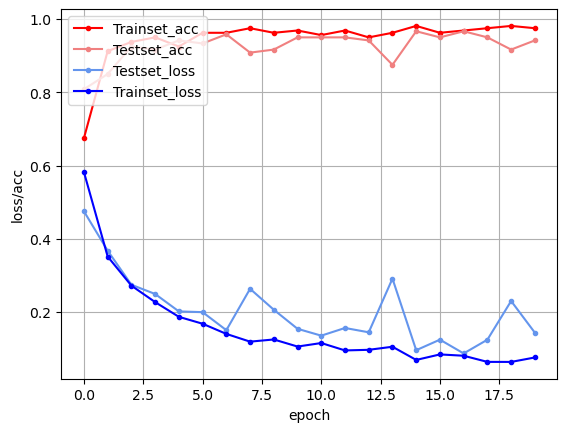

In [8]:
finetune_model.compile(loss='sparse_categorical_crossentropy', \
                      optimizer=optimizers.Adam(\
                                               learning_rate=0.0002), metrics=['accuracy'])

steps_train = len(train_generator)
steps_test = len(test_generator)

history = finetune_model.fit(
       train_generator,
       steps_per_epoch=steps_train, # step_train과 batch_size곱해서 이미지 사이즈 나와야함 
       epochs=20,
       validation_data=test_generator,
       validation_steps=steps_test )

# 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c='red', label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c='lightcoral', \
         label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c='cornflowerblue', \
         label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', \
         label='Trainset_loss')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()
